In [0]:
# Import dependencies
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from stats_helper import *
def dis_res(x):
    display(Markdown('___\n##### **Result**: \n\n' + x + '\n___'))

# Estimating the global mass of Rubisco
In the notebook  [**```leaf_mass_estimate.ipynb```**](leaf_mass_estimate.ipynb), we estimated the total mass of leaves at ≈10 Gt dry weight. In this notebook we estimate the total mass of Rubisco based on the total mass of leaves and the fraction of Rubisco out of the total mass of leaves.
We rely on a recent meta-anaylsis by [Onoda et al.](http://dx.doi.org/10.1111/nph.14496), which measured the leaf nitrogen content per leaf mass (Nmass) as well as the fraction of leaf nitrogen found in Rubisco (Nrub/N), for about a hundred different plant species.
Here is a sample of the data:

In [4]:
onoda = pd.read_excel('../data/literature_data.xlsx','Onoda')
onoda.head()

,no,Dataset,Species,Family,Growth condition,Pot/Field,Location/treatment,GF,EveDec,Aarea,...,Rubisco_area,Nrub/N,CWarea,CWmass,Nconc_in_CW,Ncw_area,Ncw/N,CW extraction,CW-N method,Ref
0,1,Feng et al. (2009),Ageratina adenophora,Asteraceae,Outdoor,Field,Mexico,H,D,12.72,...,NaN,NaN,NaN,NaN,NaN,0.110,0.093,SDS,Ninhidrin?,"Feng, Y.L., Lei, Y.B., Wang, R.F., Callaway, R..."
1,2,Feng et al. (2009),Ageratina adenophora,Asteraceae,Outdoor,Field,China,H,D,14.91,...,NaN,NaN,NaN,NaN,NaN,0.037,0.035,SDS,Ninhidrin?,"Feng, Y.L., Lei, Y.B., Wang, R.F., Callaway, R..."
2,3,Feng et al. (2009),Ageratina adenophora,Asteraceae,Outdoor,Field,India,H,D,16.63,...,NaN,NaN,NaN,NaN,NaN,0.086,0.064,SDS,Ninhidrin?,"Feng, Y.L., Lei, Y.B., Wang, R.F., Callaway, R..."
3,4,Funk et al (2013),Acacia koa,Fabaceae,Outdoor,Field,Hawaii (native),W,E,14.30,...,NaN,NaN,NaN,NaN,NaN,0.086,0.036,SDS,Ninhidrin,"Funk, J.L., Glenwinkel, L.A. & Sack, L. (2013)..."
4,5,Funk et al (2013),Dodonaea viscosa,Sapindaceae,Outdoor,Field,Hawaii (native),W,E,10.90,...,NaN,NaN,NaN,NaN,NaN,0.232,0.100,SDS,Ninhidrin,"Funk, J.L., Glenwinkel, L.A. & Sack, L. (2013)..."


The dataset contains information of species from three different growth forms: woody, and herbaceous plants. For each one of these groups, we calculate mass fraction of rubisco out of the total leaf mass by multiplying the nitrogen content per leaf mass by the fraction of leaf nitrogen in Rubisco. This gives us the total amount of rubisco nitrogen per leaf mass. To convert this result into the mass fraction of rubisco per leaf mass, we use the fact that nitrogen accounts for about a sixth of the mass of rubisco. We plot below the distribution of the mass fraction of rubisco per leaf mass for each growth form:

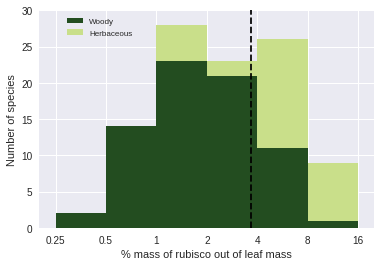

In [62]:
# Drop data with no Nrub/N and Nmass data
filt_onoda = onoda.loc[onoda[['Nrub/N','Nmass']].dropna().index]

# Calculate the mass fraction of rubisco per leaf mass
filt_onoda['Rub_frac'] = filt_onoda['Nmass']/100*filt_onoda['Nrub/N']*7

# Convert mass fraction to log scale for plotting histograms
filt_onoda['log_rub_frac'] = np.log10(filt_onoda['Rub_frac'])

filt_onoda.loc[filt_onoda['GF'] == 'G','GF'] = 'H'

rub_frac = pd.DataFrame(filt_onoda.loc[filt_onoda['GF'] == 'W','log_rub_frac'].values)
rub_frac.columns = ['Woody']
rub_frac['Herbaceous'] = pd.DataFrame(filt_onoda.loc[filt_onoda['GF'] == 'H','log_rub_frac'].values)
plt.figure(figsize=(4,4),dpi=200)
rub_frac.plot.hist(stacked=True,bins=np.log10([1e-100,0.0025,0.005,0.01,0.02,0.04,0.08,0.16,1e100]),color=['#234d20','#c9df8a'])

plt.legend(fontsize=8,bbox_to_anchor=(0.3,1))
plt.xlabel('% mass of rubisco out of leaf mass')
plt.ylabel('Number of species')
plt.ylim([0,30])
plt.xlim(np.log10([0.002,0.2]))

ax = plt.gca()

plt.vlines(np.log10(filt_onoda.groupby('GF')['Rub_frac'].apply(lambda x: gmean(x)).mean()),0,30,color='k',linestyles='dashed')
ticks = [0.25,0.5,1,2,4,8,16]
ax.set_xticks(np.log10([0.0025,0.005,0.01,0.02,0.04,0.08,0.16]))
ax.set_xticklabels(ticks)
plt.savefig('../figures/figure1_20180923.png',dpi=600)

To estimate the mean fraction of Rubisco out of the dry leaf mass, we calculate the geometric mean of the Rubisco per dry leaf mass for woody plants and for herbs separately. In the notebook [**```02_leaf_mass_estimate.ipynb```**](02_leaf_mass_estimate.ipynb)  we estimated that leaves of woody plants account for about 50% of the total leaf mass. Therefore, our best estimate for the fraction of Rubisco out of the dry leaf mass we use the average of the values for woody plants and for herbs.

In [0]:
# Calculate the geometric mean fraction of Rubisco in each growth form
rub_frac_GF_mean = filt_onoda.groupby('GF')['Rub_frac'].apply(lambda x: gmean(x))

# Calculate the average fraction of Rubisco between woody plants and herbs
best_rub_frac = rub_frac_GF_mean.mean()

We now use this mean fraction to estimate the total mass of rubisco:

In [68]:
# Our best estimate for the total leaf mass is ≈32 Gt
best_leaf_mass = 32e15

# Calculate the total mass of rubisco
tot_rub_mass = best_rub_frac*best_leaf_mass

dis_res('Our best estimate for the total mass of rubisco is ≈%.1f Gt' %(tot_rub_mass/1e15))

___
##### **Result**: 

Our best estimate for the total mass of rubisco is ≈1.2 Gt
___

## Estimating the total mass of marine rubisco
To estimate the total mass of Rubisco proteins in the marine environment, we rely on the estimate made in [Bar-On et al.](https://dx.doi.org/10.1073/pnas.1711842115) for the total mass of marine producers. Bar-On et al. estimate the total mass of marine producers at ≈1 Gt C. We assume carbon accounts for ≈50% of the dry weight of marine producers, and that proteins also account for ≈50% of the dry weight of marine producers, so we estimate the total mass of proteins in marine producers at ≈1 Gt. To estimate the mass of Rubisco out of the total mass of proteins in marine producers, we use data from several different sources on the fraction of Rubisco out of the total proteome of several different marine producer species. Here is a sample of the data:

In [0]:
marine_proteome_mass = 1e15 #Our estimate for the total mass of proteins in marine producers is 1 Gt

marine_rubisco_frac = pd.read_excel('../data/literature_data.xlsx','marine_rubisco_content')
marine_rubisco_frac.head()

,Species,Exponential,Stationary,Mean fraction of rubisco out of the proteome (%),Reference,Remarks
0,Thalassiosira weissflogii,2.5,1.2,1.85,https://doi.org/10.1111/nph.12143,Table 1
1,Thalassiosira oceanica,2.0,0.6,1.30,https://doi.org/10.1111/nph.12143,Table 1
2,Skeletonema costatum,1.4,0.8,1.10,https://doi.org/10.1111/nph.12143,Table 1
3,Chaetocerosmuelleri,3.7,0.5,2.10,https://doi.org/10.1111/nph.12143,Table 1
4,Phaeodactylum tricornutum,3.2,1.6,2.40,https://doi.org/10.1111/nph.12143,Table 1


We calculate the mean fraction of Rubisco for each species, and them use the median fraction between species as our best estimate for the characteristic fraction of Rubisco out of the proteome of marine producers:

In [0]:
best_marine_rubisco_frac = gmean(marine_rubisco_frac.groupby('Species').mean()['Mean fraction of rubisco out of the proteome (%)'])
dis_res('Our best estimate for the fraction of Rubisco out of the proteome of marine producers is %.0f' %best_marine_rubisco_frac + '%')

___
##### **Result**: 

Our best estimate for the fraction of Rubisco out of the proteome of marine producers is 3%
___

We multiply the total mass of proteins in marine producers by the characteristic fraction of Rubisco out of the total mass of proteins to estimate the total mass of marine Rubisco

In [0]:
tot_marine_rub_mass = marine_proteome_mass*best_marine_rubisco_frac/100
dis_res('Our best estimate for the total mass of marine Rubisco proteins is ≈%.2f Gt' %(tot_marine_rub_mass/1e15))

___
##### **Result**: 

Our best estimate for the total mass of marine Rubisco proteins is ≈0.03 Gt
___

# Uncertainty analysis
## Terrestrial Rubisco
First, we project the uncertainty associated with our estimate of the total mass fraction of Rubisco out of the total leaf dry mass. Then we combine this uncertainty with our uncertainty associated with our estimate of the total mass of leaves to arrive at our best projection of the uncertainty associated with our estimate of the total mass of Rubisco

In [77]:
rub_frac_CI = mul_CI(filt_onoda['Rub_frac'])
dis_res('Our projection for the uncertainty associated with our estimate for the mass fraction of Rubisco out of the total leaf dry weight is ≈%.1f-fold' %rub_frac_CI)

___
##### **Result**: 

Our projection for the uncertainty associated with our estimate for the mass fraction of Rubisco out of the total leaf dry weight is ≈2.5-fold
___

In the notebook [**```02_leaf_mass_estimate.ipynb```**](02_leaf_mass_estimate.ipynb) we project an uncertainty of ≈2-fold associated with our estimate for the total mass of leaves. We combine this uncertainty with the uncertainty associated with our estimate of the fraction of Rubisco out of the dry mass of leaves:

In [80]:
rub_mass_CI = CI_prod_prop([rub_frac_CI,2.2])
dis_res('Our projection for the uncertainty associated with our estimate for the total mass of terrestrial Rubisco is ≈%.1f-fold' %rub_mass_CI)

___
##### **Result**: 

Our projection for the uncertainty associated with our estimate for the total mass of terrestrial Rubisco is ≈3.4-fold
___

## Marine Rubisco
To project the uncertainty associated with our estimate of the total mass of marine Rubisco, we combine the uncertainties associated with the estimates of the total protein mass of marine autotrophs and the proteome fraction of Rubisco. 
[Bar-On et al.](https://dx.doi.org/10.1073/pnas.1711842115) Estimated a total of about 1.3 Gt C of marine autotrophs. This values was compared against estimates based on remote sensing from [Antonine et al.](http://dx.doi.org/10.1029/95GB02832) and [Behrenfeld & Falkowski.](http://dx.doi.org/10.4319/lo.1997.42.1.0001), who estimate ≈0.3-0.75 Gt C of phytoplankton. We use these three estimates to derive our uncertainty projection for the protein mass of marine autotrophs. The uncertainty of the conversion between carbon mass and protein mass is expected to be lower than the uncertainty associated with the estimate of the biomass of marine autotrophs and therefore we neglect it. 

In [0]:
marine_prot_CI = mul_CI([1.3,0.3,0.75])
dis_res('Our projection for the uncertainty associated with our estimate for the total biomass of marine autotrophs is ≈%.1f-fold' %marine_prot_CI)

___
##### **Result**: 

Our projection for the uncertainty associated with our estimate for the total biomass of marine autotrophs is ≈2.5-fold
___

To project the uncertainty associated with our estimate of the proteome fraction of Rubisco in marine autotrophs, we rely on the variability between the values based on which we calculate the mean proteome fraction: 

In [0]:
marine_proteome_frac_CI = mul_CI(marine_rubisco_frac.groupby('Species').mean()['Mean fraction of rubisco out of the proteome (%)'])
dis_res('Our projection for the uncertainty associated with our estimate for the proteome fraction of Rubisco in marine autotrophs is ≈%.1f-fold' % marine_proteome_frac_CI)

___
##### **Result**: 

Our projection for the uncertainty associated with our estimate for the proteome fraction of Rubisco in marine autotrophs is ≈4.5-fold
___

We combine the two uncertainties to generate our projection for the uncertainty associated with our estimate of the total mass of marine Rubisco:

In [0]:
marine_mass_CI = CI_prod_prop([marine_prot_CI,marine_proteome_frac_CI])
dis_res('Our projection for the uncertainty associated with our estimate for the total mass of marine Rubisco is ≈%.1f-fold' % marine_mass_CI)

___
##### **Result**: 

Our projection for the uncertainty associated with our estimate for the total mass of marine Rubisco is ≈5.9-fold
___